In [1]:
import math
import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pd.options.display.max_columns = 40

In [2]:
#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
# The evaluation metric used by the Kaggle competition
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [3]:
df = pd.read_pickle('Data/Processed/air_data_processed.pkl')
df['prefecture'] = [x[1] for x in df['air_area_name'].str.split()]
df['subprefecture'] = [x[2] for x in df['air_area_name'].str.split()]
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df.drop('air_area_name', inplace=True, axis=1)
df.set_index('air_store_id', append=True, inplace=True)
df.head()

is_test  visitors air_genre_name  \
calendar_date air_store_id                                             
2016-01-01    air_09a845d5b5944b01    False      56.0        Izakaya   
              air_efc80d3f96b3aff7    False      10.0          Other   
              air_298513175efdf261    False      12.0    Cafe/Sweets   
              air_5b6d18c470bbfaf9    False      21.0    Cafe/Sweets   
              air_87f9e1024b951f01    False      17.0     Dining bar   

                                           city day_of_week  holiday_flg  \
calendar_date air_store_id                                                 
2016-01-01    air_09a845d5b5944b01  Fukuoka-ken      Friday            1   
              air_efc80d3f96b3aff7     Tōkyō-to      Friday            1   
              air_298513175efdf261  Fukuoka-ken      Friday            1   
              air_5b6d18c470bbfaf9     Tōkyō-to      Friday            1   
              air_87f9e1024b951f01  Fukuoka-ken      Friday            1   

                                    avg_temperature  high_temperature  \
calendar_date air_store_id                                              
2016-01-01    air_09a845d5b5944b01         5.233333         10.933333   
              air_efc80d3f96b3aff7         6.766667         12.166667   
              air_298513175efdf261         6.550000         11.975000   
              air_5b6d18c470bbfaf9         7.750000         12.300000   
              air_87f9e1024b951f01         5.233333         10.933333   

                                    low_temperature  precipitation  \
calendar_date air_store_id                                           
2016-01-01    air_09a845d5b5944b01         0.966667            0.0   
              air_efc80d3f96b3aff7         1.400000            0.0   
              air_298513175efdf261         1.750000            0.0   
              air_5b6d18c470bbfaf9         4.100000            0.0   
              air_87f9e1024b951f01         0.966667            0.0   

                                    hours_sunlight  solar_radiation  \
calendar_date air_store_id                                            
2016-01-01    air_09a845d5b5944b01        7.166667            10.35   
              air_efc80d3f96b3aff7        9.066667            11.80   
              air_298513175efdf261        6.233333            10.35   
              air_5b6d18c470bbfaf9        9.166667            11.80   
              air_87f9e1024b951f01        7.166667            10.35   

                                    avg_wind_speed  avg_vapor_pressure  \
calendar_date air_store_id                                               
2016-01-01    air_09a845d5b5944b01        1.266667                 7.6   
              air_efc80d3f96b3aff7        1.800000                 4.5   
              air_298513175efdf261        2.200000                 7.6   
              air_5b6d18c470bbfaf9        2.975000                 4.5   
              air_87f9e1024b951f01        1.266667                 7.6   

                                    avg_local_pressure  avg_humidity  \
calendar_date air_store_id                                             
2016-01-01    air_09a845d5b5944b01              1029.2          76.0   
              air_efc80d3f96b3aff7              1022.4          45.0   
              air_298513175efdf261              1029.2          76.0   
              air_5b6d18c470bbfaf9              1022.4          45.0   
              air_87f9e1024b951f01              1029.2          76.0   

                                    avg_sea_pressure  cloud_cover  \
calendar_date air_store_id                                          
2016-01-01    air_09a845d5b5944b01            1031.1          4.3   
              air_efc80d3f96b3aff7            1025.4          2.5   
              air_298513175efdf261            1031.1          4.3   
              air_5b6d18c470bbfaf9            1025.4          2.5   
              air_87f9e1024b951f01            1031.1       

In [4]:
columns_to_drop = ['visitors', 'is_test']
X = pd.get_dummies(df)
X_train = X.loc[X['is_test'] == False].copy()
X_test = X.loc[X['is_test'] == True].copy()
y_train = df.loc[df['is_test'] == False, 'visitors'].copy()

X_train.drop(columns_to_drop, axis=1, inplace=True)
X_test.drop(columns_to_drop, axis=1, inplace=True)

In [5]:
def fit_predict(regressor, X_train, y_train, X_test, rname):
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    
    X_test = X_test.reset_index()
    submission = pd.DataFrame()
    submission['id'] = X_test['air_store_id'] + '_' + X_test['calendar_date'].astype('str')
    submission['visitors'] = y_pred
    submission.to_csv('predictions/' + rname + '.csv', index=False)

In [6]:
rfr = RandomForestRegressor(n_estimators=300, max_features='sqrt', n_jobs=-1)
fit_predict(rfr, X_train, y_train, X_test, 'rfr_300trees')

In [7]:
gbr = GradientBoostingRegressor(n_estimators=2000, max_features='sqrt', max_depth=5)
fit_predict(gbr, X_train, y_train, X_test, 'gbr_2000trees_5depth')

The random forest performs almost as well with 100 trees as the gradient boosting regressor with 1000 trees and runs much faster. They are however performing poorly compared with the competitors in the Kaggle competition.  


---
## ARIMA Model

In [8]:
submission = pd.DataFrame()
X_test = X_test.reset_index()
submission['id'] = X_test['air_store_id'] + '_' + X_test['calendar_date'].astype('str')
submission['air_store_id'] = X_test['air_store_id']
submission['visitors'] = 0

for air_store_id, visitors in y_train.reset_index().groupby('air_store_id')['visitors']:
    submission.loc[submission['air_store_id']==air_store_id, 'visitors'] = visitors.mean()
    
submission.drop('air_store_id', axis=1).to_csv('predictions/mean_per_restaurant.csv', index=False)

Simply using the mean for each restaurant is better than the random forest with no feature engineering.

In [9]:
y_train = y_train.reset_index(level='air_store_id')

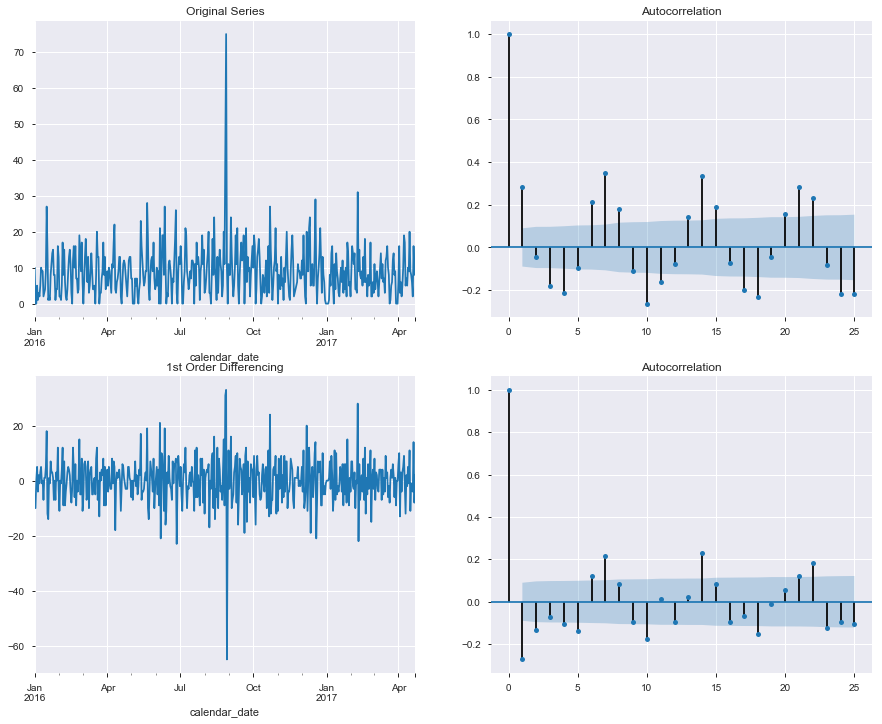

In [10]:
grouped = y_train.groupby('air_store_id')
f, axes = plt.subplots(2, 2, figsize=(15, 12))
for name, group in grouped:
    if name == 'air_efc80d3f96b3aff7':
        group = group['visitors'].resample('D').sum()
        
        group.plot(ax=axes[0, 0])
        axes[0, 0].set_title('Original Series')
        plot_acf(group, lags=25, ax=axes[0, 1])
        
        group.diff().plot(ax=axes[1, 0])
        axes[1, 0].set_title('1st Order Differencing')
        plot_acf(group.diff().dropna(), lags=25, ax=axes[1, 1])
        
        plt.show()

The original series appears to be somewhat stationary. The first order differencing definitely is, but the autocorrelation plot goes far into the negative quickly which means it is over differenced. Therefore  an ARMA model is all that is needed. Since only the first term of the autocorrelation plot is significant, the MA term should be 1.

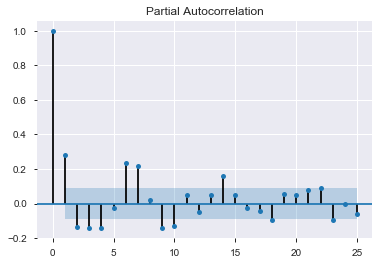

In [11]:
for name, group in grouped:
    if name == 'air_efc80d3f96b3aff7':
        group = group['visitors'].resample('D').sum()
        plot_pacf(group, lags=25)       
        plt.show()

From the partial autocorrelation plot, the AR term should be between 1 and 7 since most of the first seven are significant. 

In [12]:
for name, group in grouped:
    if name == 'air_efc80d3f96b3aff7': 
        model = ARMA(group['visitors'].resample('D').sum(), order=(7, 1))
        model_fit = model.fit(disp=0)
        print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:               visitors   No. Observations:                  478
Model:                     ARMA(7, 1)   Log Likelihood               -1542.515
Method:                       css-mle   S.D. of innovations              6.093
Date:                Thu, 14 Nov 2019   AIC                           3105.030
Time:                        10:34:38   BIC                           3146.726
Sample:                    01-01-2016   HQIC                          3121.423
                         - 04-22-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.8311      0.432     20.446      0.000       7.985       9.678
ar.L1.visitors     0.2779      0.137      2.035      0.042       0.010       0.546
ar.L2.visitors    -0.0665      0.059

The MA term is the least significant so I will remove it first.

In [13]:
for name, group in grouped:
    if name == 'air_efc80d3f96b3aff7': 
        model = ARMA(group['visitors'].resample('D').sum(), order=(7, 0))
        model_fit = model.fit(disp=0)
        print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:               visitors   No. Observations:                  478
Model:                     ARMA(7, 0)   Log Likelihood               -1542.576
Method:                       css-mle   S.D. of innovations              6.094
Date:                Thu, 14 Nov 2019   AIC                           3103.152
Time:                        10:34:39   BIC                           3140.679
Sample:                    01-01-2016   HQIC                          3117.906
                         - 04-22-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.8326      0.427     20.687      0.000       7.996       9.669
ar.L1.visitors     0.2324      0.045      5.212      0.000       0.145       0.320
ar.L2.visitors    -0.0536      0.045

The second term is not significant, so I will go to a first order autoregressive model.

In [14]:
for name, group in grouped:
    if name == 'air_efc80d3f96b3aff7':
        model = ARMA(group['visitors'].resample('D').sum(), order=(1, 0))
        model_fit = model.fit(disp=0)
        print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:               visitors   No. Observations:                  478
Model:                     ARMA(1, 0)   Log Likelihood               -1581.223
Method:                       css-mle   S.D. of innovations              6.613
Date:                Thu, 14 Nov 2019   AIC                           3168.446
Time:                        10:34:39   BIC                           3180.955
Sample:                    01-01-2016   HQIC                          3173.364
                         - 04-22-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.8680      0.421     21.085      0.000       8.044       9.692
ar.L1.visitors     0.2815      0.044      6.422      0.000       0.196       0.367
                                    

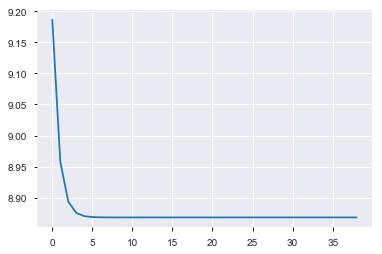

In [15]:
for name, group in grouped:
    if name == 'air_efc80d3f96b3aff7':
        model = ARMA(group['visitors'].resample('D').sum(), order=(1, 0))
        model_fit = model.fit(disp=0)
        plt.plot(model_fit.forecast(steps=39)[0])

This shows no weekly variation.

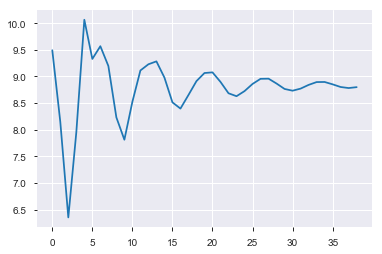

In [16]:
for name, group in grouped:
    if name == 'air_efc80d3f96b3aff7':
        model = ARMA(group['visitors'].resample('D').sum(), order=(7, 0))
        model_fit = model.fit(disp=0)
        plt.plot(model_fit.forecast(steps=39)[0])

Now there is a weekly variation, but it gets smaller as the forecasting gets farther from the known data. This is likely not realistic, but it is better than no variation.

In [17]:
grouped = y_train.groupby('air_store_id')
ARMA_models = {}
for name, group in grouped:
    model = ARMA(group['visitors'].resample('D').sum(), order=(7, 0))
    model_fit = model.fit(disp=0)
    ARMA_models[name] = model_fit

D:\Anaconda\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [18]:
submission = pd.DataFrame()
X_test.reset_index(inplace=True)
submission['id'] = X_test['air_store_id'] + '_' + X_test['calendar_date'].astype('str')
submission['air_store_id'] = X_test['air_store_id']
submission['visitors'] = 0

In [19]:
for store, model in ARMA_models.items():
    closed_stores = ['air_0ead98dd07e7a82a', 'air_229d7e508d9f1b5e', 'air_2703dcb33192b181', 'air_b2d8bc9c88b85f96',
                     'air_cb083b4789a8d3a2', 'air_cf22e368c1a71d53', 'air_d0a7bd3339c3d12a', 'air_d63cfa6d6ab78446']
    if store in closed_stores:
        continue
    else:
        submission.loc[submission['air_store_id']==store,'visitors'] = model.forecast(steps=39)[0]

In [20]:
submission.drop('air_store_id', axis=1).to_csv('predictions/ARMA.csv', index=False)

This did much better than than the random forest and the mean per restaurant. The best RMSLE achieved with the random forest was just under 0.79 and the mean scored 0.64 while these ARMA models scored ~0.56 and the best scores are 0.50.

I will now use all the features in an ARIMAX model. This model needs every variable for every restaurant on every day. The dataset used above does not have the features available when the restaurant was closed. I will reload the data to make this possible.

In [21]:
store_info = pd.read_csv('Data/air_store_info.csv')
visit_data = pd.read_csv('Data/air_visit_data.csv')
date_info = pd.read_csv('Data/date_info.csv')
test = pd.read_csv('Data/sample_submission.csv')
weather = pd.read_csv('Data/Processed/average_weather.csv')
air_store_weather = pd.read_csv('Data/Weather/air_store_info_with_nearest_active_station.csv')

In [22]:
air_store_weather.set_index('air_store_id', inplace=True)
air_store_weather['location'] = ('(' + air_store_weather['latitude_str'].str.strip('\"') + ', ' +
                                 air_store_weather['longitude_str'].str.strip('\"') + ')')

In [23]:
test['air_store_id'] = test['id'].str.slice(0, 20)
test['calendar_date'] = test['id'].str.slice(21)
test['calendar_date'] = pd.to_datetime(test['calendar_date'])
test['visitors'] = np.nan
test['is_test'] = True

visit_data.columns = ['air_store_id', 'calendar_date', 'visitors']
visit_data.index = pd.to_datetime(visit_data['calendar_date'])
visit_data = visit_data.groupby('air_store_id').apply(lambda g: g['visitors'].resample('1d').sum()).reset_index()
visit_data['was_closed'] = visit_data['visitors']==0
visit_data_all = pd.concat((visit_data, test.drop('id', axis='columns')), sort=True)
visit_data_all['is_test'].fillna(False, inplace=True)

In [24]:
date_info['calendar_date'] = pd.to_datetime(date_info['calendar_date'])
weather['calendar_date'] = pd.to_datetime(weather['calendar_date'])

In [25]:
df = (date_info
      .merge(visit_data_all, how='left', on='calendar_date')
      .merge(store_info, how='left', on='air_store_id')
      .merge(air_store_weather['location'], how='left', on='air_store_id')
      .merge(weather, how='left', on=['location', 'calendar_date'])
)

df['city'] = [x[0] for x in df['air_area_name'].str.split()]
df['prefecture'] = [x[1] for x in df['air_area_name'].str.split()]
df['subprefecture'] = [x[2] for x in df['air_area_name'].str.split()]
df.drop('air_area_name', inplace=True, axis=1)
df.drop(columns=['total_snowfall', 'deepest_snowfall'], inplace=True)

def fill_missing_weather(row):
    for col in missing_cols:
        if np.isnan(row[col]):
            row[col] = fill_values_city_date[col][(row['city'], row['calendar_date'])]
            if np.isnan(row[col]):
                row[col] = fill_values_date[col][row['calendar_date']]
    return row

missing_cols = ['solar_radiation', 'visitors','cloud_cover', 'avg_humidity',
                'avg_vapor_pressure', 'avg_local_pressure', 'avg_sea_pressure', 'avg_wind_speed']
fill_values_city_date = df.groupby(by=['city', 'calendar_date'])[missing_cols].mean().to_dict()
fill_values_date = df.groupby(by=['calendar_date'])[missing_cols].mean().to_dict()
df.loc[df.isna().any(axis=1)] = df[df.isna().any(axis=1)].apply(fill_missing_weather, axis=1)

df['calendar_date'] = pd.to_datetime(df['calendar_date'])
df['year'] = df['calendar_date'].dt.year
df['month'] = df['calendar_date'].dt.month
df['day'] = df['calendar_date'].dt.day
df.set_index(['air_store_id', 'calendar_date'], inplace=True)


In [26]:
df.to_csv('Data/Processed/air_data_all_days.csv')
df.to_pickle('Data/Processed/air_data_all_days.pkl')

In [27]:
df.head()

,,day_of_week,holiday_flg,is_test,visitors,was_closed,air_genre_name,latitude,longitude,location,avg_temperature,high_temperature,low_temperature,precipitation,hours_sunlight,solar_radiation,avg_wind_speed,avg_vapor_pressure,avg_local_pressure,avg_humidity,avg_sea_pressure,cloud_cover,city,prefecture,subprefecture,year,month,day
air_store_id,calendar_date,,,,,,,,,,,,,,,,,,,,,,,,,,,
air_04341b588bde96cd,2016-01-01,Friday,1,False,10.0,False,Izakaya,35.735623,139.651658,"(35.7356234, 139.6516577)",6.625000,12.000000,1.450000,0.0,9.175000,11.80,1.925000,4.5,1022.4,45.0,1025.4,2.5,Tōkyō-to,Nerima-ku,Toyotamakita,2016,1,1
air_05c325d315cc17f5,2016-01-01,Friday,1,False,29.0,False,Izakaya,33.589216,130.392813,"(33.5892157, 130.3928134)",6.550000,11.975000,1.750000,0.0,6.233333,10.35,2.200000,7.6,1029.2,76.0,1031.1,4.3,Fukuoka-ken,Fukuoka-shi,Daimyō,2016,1,1
air_08ba8cd01b3ba010,2016-01-01,Friday,1,False,11.0,False,Izakaya,38.269076,140.870403,"(38.2690761, 140.8704029)",2.466667,6.333333,-1.833333,0.3,4.950000,5.71,3.300000,4.6,1019.1,64.0,1024.7,4.0,Miyagi-ken,Sendai-shi,Kamisugi,2016,1,1
air_09a845d5b5944b01,2016-01-01,Friday,1,False,56.0,False,Izakaya,33.319286,130.508374,"(33.3192865, 130.5083735)",5.233333,10.933333,0.966667,0.0,7.166667,10.35,1.266667,7.6,1029.2,76.0,1031.1,4.3,Fukuoka-ken,Kurume-shi,Jōnanmachi,2016,1,1
air_1f7f8fa557bc0d55,2016-01-01,Friday,1,False,6.0,False,Bar/Cocktail,34.766093,135.628100,"(34.7660929, 135.6280998)",5.000000,10.200000,0.900000,0.1,7.450000,11.94,1.500000,6.1,1019.4,59.0,1029.7,1.0,Ōsaka-fu,Neyagawa-shi,Honmachi,2016,1,1


In [28]:
X = pd.get_dummies(df.drop('location', axis=1))
train = X.loc[X['is_test'] == False].drop('is_test', axis=1)
test = X.loc[X['is_test'] == True].drop('is_test', axis=1)

train.reset_index(level='air_store_id', inplace=True)
test.reset_index(level='air_store_id', inplace=True)

In [29]:
grouped = train.groupby('air_store_id')
for name, group in grouped:
    if name == 'air_efc80d3f96b3aff7':
        model = SARIMAX(endog=group['visitors'], exog=group.drop(['visitors', 'air_store_id'], axis=1), order=(7, 0, 1))
        model_fit = model.fit(disp=0)
        print(model_fit.summary())

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:               visitors   No. Observations:                  478
Model:               SARIMAX(7, 0, 1)   Log Likelihood               -1473.132
Date:                Thu, 14 Nov 2019   AIC                           3372.264
Time:                        10:39:24   BIC                           4260.392
Sample:                    01-01-2016   HQIC                          3721.429
                         - 04-22-2017                                         
Covariance Type:                  opg                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
holiday_flg                                     0.3765      1.305      0.288      0.773      -2.181       2.934
latitude                        

Most of the categorical variables have no effect on this model. I will remove them and run again.

In [30]:
columns_to_drop = ['location', 'city', 'prefecture', 'subprefecture', 'air_genre_name']
X = pd.get_dummies(df.drop(columns_to_drop, axis=1))
train = X.loc[X['is_test'] == False].drop('is_test', axis=1)
test = X.loc[X['is_test'] == True].drop('is_test', axis=1)

train.reset_index(level='air_store_id', inplace=True)
test.reset_index(level='air_store_id', inplace=True)

In [31]:
grouped = train.groupby('air_store_id')
for name, group in grouped:
    if name == 'air_efc80d3f96b3aff7':
        model = SARIMAX(group['visitors'], group.drop(['visitors', 'air_store_id'], axis=1), order=(7, 0, 1),
                        time_varying_regression=True, mle_regression=False)
        model_fit = model.fit(disp=0)
        print(model_fit.summary())

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:               visitors   No. Observations:                  478
Model:               SARIMAX(7, 0, 1)   Log Likelihood               -2938.403
Date:                Thu, 14 Nov 2019   AIC                           5948.807
Time:                        10:40:39   BIC                           6096.819
Sample:                    01-01-2016   HQIC                          6007.139
                         - 04-22-2017                                         
Covariance Type:                  opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
ar.L1                        -2.7945      2.769     -1.009      0.313      -8.221       2.632
ar.L2                        -3.5655      7.193     -0.496      0.620     -17.664     

None of the variables are signifcant in this model. I will attempt to use this model.

In [32]:
# train_grouped = train.groupby('air_store_id')
# test_grouped = test.groupby('air_store_id')
# submission = pd.DataFrame()
# #X_test.reset_index(inplace=True)
# submission['id'] = X_test['air_store_id'] + '_' + X_test['calendar_date'].astype('str')
# submission['air_store_id'] = X_test['air_store_id']
# submission['visitors'] = 0
# submission_grouped = submission.groupby('air_store_id')
# closed_stores = ['air_0ead98dd07e7a82a', 'air_229d7e508d9f1b5e', 'air_2703dcb33192b181', 'air_b2d8bc9c88b85f96',
#                  'air_cb083b4789a8d3a2', 'air_cf22e368c1a71d53', 'air_d0a7bd3339c3d12a', 'air_d63cfa6d6ab78446']

# for name, group in train_grouped:
#     if name in closed_stores:
#         continue
#     else:
#         print(name)
#         model = SARIMAX(endog=group['visitors'].asfreq('D'),
#                         exog=group.drop(['visitors', 'air_store_id'], axis=1).asfreq('D'),
#                         order=(7, 0, 1),
#                         time_varying_regression=True,
#                         mle_regression=False
#                        )
#         model_fit = model.fit(disp=0)
#         submission.loc[submission['air_store_id']==name,'visitors'] = model_fit.forecast(steps=39,
#                                                                        exog=(test_grouped
#                                                                        .get_group(name)
#                                                                        .drop(['visitors', 'air_store_id'], axis=1)
#                                                                        .asfreq('D'))
#                                                                       ).values
        
# submission.drop('air_store_id', axis=1).to_csv('predictions/ARIMAX.csv', index=False)

This model does not converge for most stores and then throws an error when fitting a certain store. Another way of getting the advantage of an ARIMA model and other features is to add the ARIMA prediction as a column and then use a forest model for prediction.

In [33]:
df = pd.read_pickle('Data/Processed/air_data_all_days.pkl')

In [34]:
visitors_pred_ARMA = pd.DataFrame()
for store_id, model in ARMA_models.items():
    temp = pd.concat([ARMA_models[store_id].predict(),
                      pd.DataFrame(ARMA_models[store_id].forecast(39)[0],
                                   index=pd.date_range(start='2017-04-23', end='2017-05-31'))
                     ])
    temp['air_store_id'] = store_id
    
    visitors_pred_ARMA = pd.concat([visitors_pred_ARMA, temp], axis=0)
visitors_pred_ARMA.columns = ['visitors_pred_ARMA', 'air_store_id']
visitors_pred_ARMA.index = visitors_pred_ARMA.index.rename('calendar_date')
visitors_pred_ARMA.set_index('air_store_id', append=True, inplace=True)
visitors_pred_ARMA.sort_index(inplace=True)

In [35]:
df = df.merge(visitors_pred_ARMA, how='left', on=['calendar_date', 'air_store_id'])

In [36]:
columns_to_drop = ['visitors', 'is_test']
X = pd.get_dummies(df)
X_train = X.loc[X['is_test'] == False].copy()
X_test = X.loc[X['is_test'] == True].copy()
y_train = df.loc[df['is_test'] == False, 'visitors'].copy()

X_train.drop(columns_to_drop, axis=1, inplace=True)
X_test.drop(columns_to_drop, axis=1, inplace=True)

In [37]:
rfr_ARMA = RandomForestRegressor(n_estimators=100, max_features='sqrt', n_jobs=-1)
fit_predict(rfr, X_train, y_train, X_test, 'rfr_ARMA_100trees')

This random forest model that has as a column the ARMA predictions performed much better than without it, but slightly worse than the ARMA predictions themselves.

In [38]:
# This is largely a function used by Max Halford in his solution to this contest
# https://github.com/MaxHalford/kaggle-recruit-restaurant/blob/master/Solution.ipynb

def extract_statistics(df, on, group_by):
    
    df.sort_values(group_by + ['calendar_date'], inplace=True)
    
    groups = df.groupby(group_by, sort=False)
    
    stats = {
        'mean': [],
        'median': [],
        'std': [],
        'max': [],
        'min': []
    }
    
    exp_alphas = [0.1, 0.25, 0.3, 0.5, 0.75]
    stats.update({'exp_{}_mean'.format(alpha): [] for alpha in exp_alphas})
    
    for _, group in groups:
        shift = group[on].shift()
        roll = shift.rolling(window=len(group), min_periods=1)
        
        stats['mean'].extend(roll.mean())
        stats['median'].extend(roll.median())
        stats['std'].extend(roll.std())
        stats['max'].extend(roll.max())
        stats['min'].extend(roll.min())
        
        for alpha in exp_alphas:
            exp = shift.ewm(alpha=alpha, adjust=False)
            stats['exp_{}_mean'.format(alpha)].extend(exp.mean())
    
    suffix = '_&_'.join(group_by)
    
    for stat_name, values in stats.items():
        df['{}_{}_by_{}'.format(on, stat_name, suffix)] = values

In [39]:
extract_statistics(df=df, on='visitors', group_by=['air_store_id'])
extract_statistics(df=df, on='visitors', group_by=['air_store_id', 'day_of_week'])

In [40]:
columns_to_drop = ['visitors', 'is_test', 'was_closed_False', 'was_closed_True']
df_dummy = pd.get_dummies(df)
train = df_dummy.loc[(df_dummy['is_test'] == False) & (df_dummy['was_closed_False'])].copy()
train.dropna(inplace=True)
test = df_dummy.loc[df_dummy['is_test']].copy()

X_train = train.drop(columns_to_drop, axis=1)
y_train = train.loc[train['is_test'] == False, 'visitors'].copy()
X_test = test.drop(columns_to_drop, axis=1)

In [41]:
rfr_ARMA = RandomForestRegressor(n_estimators=100, max_features='sqrt', n_jobs=-1)
fit_predict(rfr_ARMA, X_train, y_train, X_test, 'rfr_ARMA_stats_100trees')